In [253]:
#import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [166]:
#Setting the random seed 
import random
seed = 42
np.random.seed(seed) 
random.seed(seed)

In [167]:
#Importing data
data = pd.read_excel('default of credit card clients.xls',header=1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [168]:
#replace values 0, 5, 6 with 4 (others category) since they are not mentioned in the data description
data['EDUCATION'].replace([0,5,6],4,inplace=True)
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [169]:
#initial preprocessing: drop 'ID' column, rename target column to DEFAULT, rename PAY_0 to PAY_1 for consistency 
data.drop(columns='ID',inplace=True)
data.rename(columns={"default payment next month": "DEFAULT","PAY_0": "PAY_1"},inplace=True)

In [170]:
#train test split (30%) before scaling and encoding to prevent data leakage 
X_train, X_test, y_train, y_test = train_test_split(data.drop('DEFAULT',axis=1),data['DEFAULT'],test_size=0.3,stratify=data['DEFAULT'])

In [171]:
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
11018,160000,2,2,2,32,0,0,0,0,0,...,155404,153234,156731,155818,6000,6000,5600,6000,6000,5500
1710,100000,2,1,2,30,0,0,0,0,2,...,42283,51539,50583,52588,5000,10000,10000,0,2846,1936
4618,80000,1,1,2,29,0,0,0,0,0,...,64277,45455,42231,42804,3300,2500,1556,1600,1600,1600
5482,20000,2,2,1,27,0,0,-1,-1,-2,...,780,0,0,0,1006,780,0,0,0,0
26187,50000,2,1,2,30,-2,-2,-2,-2,-2,...,0,0,0,0,2070,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25780,200000,2,2,1,32,0,0,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
13921,120000,2,2,2,24,0,0,0,0,0,...,115515,113948,122127,121962,4200,4100,4100,10000,4560,0
3794,120000,2,1,2,24,0,0,0,0,0,...,67187,49924,33188,19826,3700,2023,2016,2000,1200,1000
27565,360000,1,1,1,57,1,-2,-1,-1,-1,...,860,246,-46,-46,0,860,246,0,0,0


In [172]:
#one hot encode categorical features and drop the first generated column to prevent multicollinearity
#first ohe train and save columns to apply to test set
X_train_encoded = pd.get_dummies(X_train, columns = ['EDUCATION','MARRIAGE'], drop_first = True)
cols_train = X_train_encoded.columns.tolist()

In [173]:
#ohe X_test and apply the same columns from X_train_encoded
X_test_encoded = pd.get_dummies(X_test,columns = ['EDUCATION','MARRIAGE'], drop_first = True)
X_test_encoded = X_test_encoded.reindex(columns = cols_train).fillna(0)   #if unknown columns assign 0

In [174]:
#numerical columns
numerical_cols = ['LIMIT_BAL', 'AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [175]:
#Scaling numerical features
scaler = RobustScaler()

# Fit and transform the scaler on the training data
X_train_scaled_encoded = copy.deepcopy(X_train_encoded)
X_train_scaled_encoded[numerical_cols] = scaler.fit_transform(X_train_encoded[numerical_cols])

# Transform the test data using the fitted scaler
X_test_scaled_encoded = copy.deepcopy(X_test_encoded)
X_test_scaled_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])

In [176]:
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)

In [177]:
X_train_SMOTE = copy.deepcopy(X_train_scaled_encoded)
y_train_SMOTE = copy.deepcopy(y_train)

In [178]:
X_train_SMOTE, y_train_SMOTE =  pipeline.fit_resample(X_train_SMOTE, y_train_SMOTE)

In [179]:
X_train_SMOTE

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0.789474,1,0.153846,0,0,0,0,0,0,2.087982,...,0.633848,0.131848,0.209414,0.362051,1,0,0,1,0,0
1,0.315789,2,0.153846,-1,-1,-1,-1,-1,-1,-0.310379,...,-0.282542,-0.395544,-0.226482,-0.384615,1,0,0,1,0,0
2,0.315789,1,-0.461538,0,0,0,0,0,0,3.117359,...,0.754988,2.768805,1.179413,1.410256,0,0,0,0,1,0
3,-0.684211,2,0.230769,0,-1,0,0,0,0,-0.192367,...,-0.195131,-0.263696,-0.264820,-0.256410,1,0,0,1,0,0
4,0.736842,2,-0.384615,0,0,0,0,0,0,1.999693,...,0.945012,1.160261,1.205672,1.179487,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19621,-0.631579,1,0.708271,0,0,0,0,0,0,-0.144369,...,-0.081657,-0.245543,-0.205891,-0.238786,1,0,0,1,0,0
19622,-0.610531,1,-0.400045,1,-2,-2,-2,-2,-2,-0.349716,...,-0.432660,-0.395544,-0.396114,-0.384615,1,0,0,1,0,0
19623,-0.191171,1,-0.538462,1,2,0,0,0,0,0.570358,...,0.057892,0.127288,0.216707,-0.109346,1,0,0,0,1,0
19624,-0.124371,2,0.014210,-1,2,2,-1,-1,0,-0.339591,...,-0.396786,-0.103777,-0.356455,-0.345890,0,0,0,1,0,0


In [180]:
temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
static_cols = ['LIMIT_BAL', 'SEX', 'AGE','EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3']

In [181]:
X_train_temp = X_train_SMOTE[temp_cols]
X_train_static = X_train_SMOTE[static_cols]
X_test_temp = X_test_scaled_encoded[temp_cols]
X_test_static = X_test_scaled_encoded[static_cols]

In [182]:
#3 temporal features in reverse column order (April to September)
PAY = X_train_temp.iloc[:,5::-1]
BILL_AMT = X_train_temp.iloc[:,11:5:-1]
PAY_AMT = X_train_temp.iloc[:,:11:-1]

PAY = PAY.to_numpy()
BILL_AMT = BILL_AMT.to_numpy()
PAY_AMT = PAY_AMT.to_numpy()

#3D array with 21000 customers on y axis, 6 months on x axis, 3 features per month on z axis 
stacked = np.dstack((PAY,BILL_AMT,PAY_AMT))

y_train_array = y_train_SMOTE.to_numpy()

In [216]:
X_train_temp.iloc[:,11:5:-1]

,BILL_AMT6,BILL_AMT5,BILL_AMT4,BILL_AMT3,BILL_AMT2,BILL_AMT1
0,0.974694,0.913249,1.797732,5.301113,2.260355,2.087982
1,-0.342696,-0.373344,-0.351184,-0.254112,-0.343372,-0.310379
2,2.935962,2.977223,2.721849,3.173873,3.163054,3.117359
3,0.019701,-0.195315,-0.205119,-0.220193,-0.222023,-0.192367
4,3.105511,2.968910,2.675042,2.365177,2.148100,1.999693
...,...,...,...,...,...,...
19621,-0.014537,-0.033816,-0.056786,-0.084199,-0.107678,-0.144369
19622,-0.356206,-0.373344,-0.363278,-0.349169,-0.343372,-0.349716
19623,0.640866,0.589203,0.514246,0.605921,0.533255,0.570358
19624,-0.347639,-0.360612,-0.365775,-0.347823,-0.336244,-0.339591


In [204]:
BILL_AMT

array([[ 0.97469413,  0.91324907,  1.79773238,  5.30111274,  2.26035469,
         2.08798168],
       [-0.34269581, -0.37334406, -0.35118404, -0.25411227, -0.34337214,
        -0.31037874],
       [ 2.93596152,  2.97722292,  2.72184854,  3.17387341,  3.16305392,
         3.11735874],
       ...,
       [ 0.64086571,  0.58920257,  0.51424588,  0.6059214 ,  0.5332554 ,
         0.5703579 ],
       [-0.34763922, -0.36061168, -0.36577525, -0.34782281, -0.33624366,
        -0.33959115],
       [-0.35620621, -0.37334406, -0.363278  , -0.34916882, -0.34337214,
        -0.34971599]])

In [215]:
stacked[0,:,1]

array([0.97469413, 0.91324907, 1.79773238, 5.30111274, 2.26035469,
       2.08798168])

In [183]:
#3 temporal features in reverse column order (April to September)
PAY_test = X_test_temp.iloc[:,5::-1]
BILL_AMT_test = X_test_temp.iloc[:,11:5:-1]
PAY_AMT_test = X_test_temp.iloc[:,:11:-1]

PAY_test = PAY_test.to_numpy()
BILL_AMT_test = BILL_AMT_test.to_numpy()
PAY_AMT_test = PAY_AMT_test.to_numpy()

#3D array with 21000 customers on y axis, 6 months on x axis, 3 features per month on z axis 
stacked_test = np.dstack((PAY_test,BILL_AMT_test,PAY_AMT_test))

y_test_array = y_test.to_numpy()

In [291]:
stacked.shape[2]

3

In [341]:
num_time_steps, num_features = stacked.shape[1], stacked.shape[2]

# Define the LSTM model
model = Sequential()
model.add(LSTM(64,return_sequences=True, input_shape=(num_time_steps, num_features)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 40
batch_size = 256

model.fit(stacked, y_train_array, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_array),shuffle=False)

# Make predictions on the test set
y_pred_probs = model.predict(stacked_test)
y_pred = (y_pred_probs>=0.5).astype(int)

# Evaluate the model
loss, accuracy = model.evaluate(stacked_test, y_test_array)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/40
77/77 [==============================] - 4s 20ms/step - loss: 0.9192 - accuracy: 0.6491 - val_loss: 0.5629 - val_accuracy: 0.7914
Epoch 2/40
77/77 [==============================] - 1s 10ms/step - loss: 0.6374 - accuracy: 0.7185 - val_loss: 0.5712 - val_accuracy: 0.7841
Epoch 3/40
77/77 [==============================] - 1s 10ms/step - loss: 0.6282 - accuracy: 0.7161 - val_loss: 0.5656 - val_accuracy: 0.7843
Epoch 4/40
77/77 [==============================] - 1s 10ms/step - loss: 0.6216 - accuracy: 0.7182 - val_loss: 0.5635 - val_accuracy: 0.7847
Epoch 5/40
77/77 [==============================] - 1s 11ms/step - loss: 0.6173 - accuracy: 0.7200 - val_loss: 0.5610 - val_accuracy: 0.7866
Epoch 6/40
77/77 [==============================] - 1s 11ms/step - loss: 0.6120 - accuracy: 0.7232 - val_loss: 0.5570 - val_accuracy: 0.7879
Epoch 7/40
77/77 [==============================] - 1s 13ms/step - loss: 0.6076 - accuracy: 0.7255 - val_loss: 0.5532 - val_accuracy: 0.7899
Epoch 8/40
77

In [342]:
print('Accuracy:', accuracy_score(y_test_array,y_pred))
print('Precision:', precision_score(y_test_array,y_pred))
print('Recall:', recall_score(y_test_array,y_pred))
print('F1 score:', f1_score(y_test_array,y_pred))

Accuracy: 0.806
Precision: 0.57847533632287
Recall: 0.4535409342039176
F1 score: 0.5084459459459459


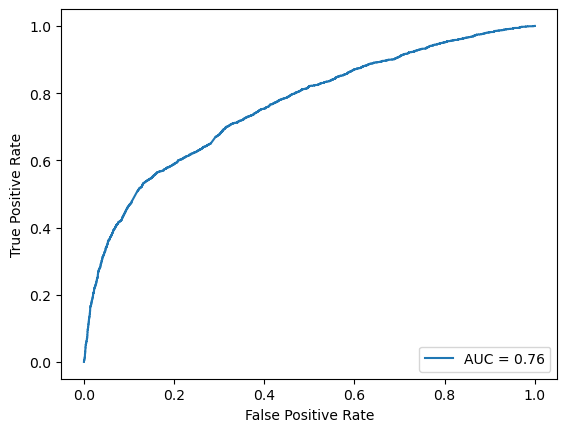

In [343]:
# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_array, y_pred_probs)

# Calculate the AUC score
auc_score = roc_auc_score(y_test_array, y_pred_probs)

# Plot the ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score)
roc_display.plot()
plt.show()

Reminder: only temporal features:
 
Accuracy: 0.8065555555555556

Precision: 0.5763125763125763

Recall: 0.4741336012054244

F1 score: 0.5202535133645633

In [371]:
# Define input shape and number of classes
input_shape = stacked.shape[1:]  # (6, 3)
num_classes = 2

# Define the input layer
X_in = Input(shape=input_shape)

# Add Graph Convolutional layers
X = GCNConv(32, activation='relu')([X_in])
X = GCNConv(64, activation='relu')([X])

# Reshape to match the LSTM output shape
X = Flatten()(X)

# Add output layer
output = Dense(num_classes, activation='sigmoid')(X)

# Build the model
model_GNN = Model(inputs=X_in, outputs=output)

# Compile the model
model_GNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_GNN.fit(stacked, y_train_array, epochs=40, batch_size=256, validation_data=(stacked_test, y_test_array), shuffle=False)

# Make predictions on the test set
y_pred_probs_GNN = model_GNN.predict(stacked_test)
y_pred_GNN = (y_pred_probs_GNN >= 0.5).astype(int)

# Evaluate the model
loss_GNN, accuracy_GNN = model_GNN.evaluate(stacked_test, y_test_array)
print(f'Test Loss: {loss_GNN:.4f}')
print(f'Test Accuracy: {accuracy_GNN:.4f}')


AssertionError: 

In [267]:
# Get the output features from the LSTM layer
lstm_output = model.layers[0].output

# Create an input layer for the static features
static_input = Input(shape=(X_train_static.shape[1],))  # Assuming num_static_features is the number of static features in X_train_static

# Concatenate the LSTM output with the static input
concatenated_output = Concatenate()([lstm_output, static_input])

# Add a dense layer with one neuron after the concatenation
output = Dense(1, activation='sigmoid')(concatenated_output)

# Create the final model with the concatenated input and the dense layer
final_model = Model(inputs=[model.input, static_input], outputs=output)

# Compile the final model
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the final model
epochs = 20
batch_size = 512

final_model.fit([stacked, X_train_static], y_train_array, epochs=epochs, batch_size=batch_size, validation_data=([stacked_test, X_test_static], y_test_array),shuffle=False)

# Make predictions on the test set
y_pred_probs2 = final_model.predict([stacked_test, X_test_static])
y_pred2 = (y_pred_probs2 >= 0.5).astype(int)

# Evaluate the final model
loss2, accuracy2 = final_model.evaluate([stacked_test, X_test_static], y_test_array)
print(f'Test Loss: {loss2:.4f}')
print(f'Test Accuracy: {accuracy2:.4f}')

Epoch 1/20
39/39 [==============================] - 3s 26ms/step - loss: 0.6890 - accuracy: 0.6540 - val_loss: 0.5196 - val_accuracy: 0.7903
Epoch 2/20
39/39 [==============================] - 0s 12ms/step - loss: 0.5807 - accuracy: 0.7335 - val_loss: 0.5048 - val_accuracy: 0.7924
Epoch 3/20
39/39 [==============================] - 0s 12ms/step - loss: 0.5676 - accuracy: 0.7382 - val_loss: 0.4989 - val_accuracy: 0.7959
Epoch 4/20
39/39 [==============================] - 0s 12ms/step - loss: 0.5607 - accuracy: 0.7420 - val_loss: 0.4944 - val_accuracy: 0.7972
Epoch 5/20
39/39 [==============================] - 0s 12ms/step - loss: 0.5555 - accuracy: 0.7454 - val_loss: 0.4908 - val_accuracy: 0.7981
Epoch 6/20
39/39 [==============================] - 0s 12ms/step - loss: 0.5512 - accuracy: 0.7486 - val_loss: 0.4878 - val_accuracy: 0.7987
Epoch 7/20
39/39 [==============================] - 1s 17ms/step - loss: 0.5477 - accuracy: 0.7511 - val_loss: 0.4853 - val_accuracy: 0.8007
Epoch 8/20
39

In [268]:
print('Accuracy:', accuracy_score(y_test_array,y_pred2))
print('Precision:', precision_score(y_test_array,y_pred2))
print('Recall:', recall_score(y_test_array,y_pred2))
print('F1 score:', f1_score(y_test_array,y_pred2))

Accuracy: 0.8068888888888889
Precision: 0.5804195804195804
Recall: 0.4585635359116022
F1 score: 0.5123456790123457


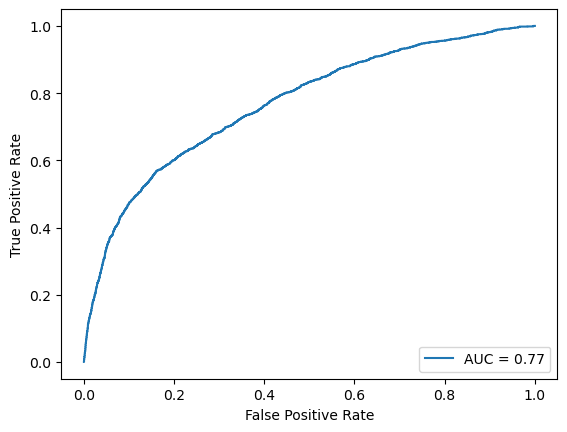

In [269]:
# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr2, tpr2, thresholds2 = roc_curve(y_test_array, y_pred_probs2)

# Calculate the AUC score
auc_score2 = roc_auc_score(y_test_array, y_pred_probs2)

# Plot the ROC curve
roc_display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2, roc_auc=auc_score2)
roc_display2.plot()
plt.show()

In [52]:
#x test
features_layer1 = Model(
    inputs=model.inputs,
    outputs=model.get_layer(index=0).output,
)

inter_test = features_layer1.predict(stacked_test)

282/282 [==============================] - 1s 2ms/step


In [53]:
#x train
features_layer2 = Model(
    inputs=model.inputs,
    outputs=model.get_layer(index=0).output,
)

inter_train = features_layer1.predict(stacked)

614/614 [==============================] - 1s 2ms/step


In [54]:
import xgboost as xgb

In [193]:
#ARXIKO INPUT

# Train an XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_SMOTE, y_train_SMOTE)

# Make predictions on the validation set
y_pred3 = xgb_model.predict(X_test_scaled_encoded)

print('Accuracy:', accuracy_score(y_test,y_pred3))
print('Precision:', precision_score(y_test,y_pred3))
print('Recall:', recall_score(y_test,y_pred3))
print('F1 score:', f1_score(y_test,y_pred3))


Accuracy: 0.8018888888888889
Precision: 0.56951871657754
Recall: 0.42792566549472627
F1 score: 0.48867221106968745


In [194]:
#INPUT AFTER LSTM

# Train an XGBoost model
xgb_model2 = xgb.XGBClassifier()
xgb_model2.fit(inter_train, y_train_array)

# Make predictions on the validation set
y_pred4 = xgb_model2.predict(inter_test)

print('Accuracy:', accuracy_score(y_test_array,y_pred4))
print('Precision:', precision_score(y_test_array,y_pred4))
print('Recall:', recall_score(y_test_array,y_pred4))
print('F1 score:', f1_score(y_test_array,y_pred4))

Accuracy: 0.792
Precision: 0.5344927536231884
Recall: 0.4630838774485183
F1 score: 0.49623250807319697


In [195]:
from sklearn.ensemble import RandomForestClassifier
#ARXIKO INPUT

# Train an RF model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_SMOTE, y_train_SMOTE)

# Make predictions on the validation set
y_pred5 = rf_model.predict(X_test_scaled_encoded)

print('Accuracy:', accuracy_score(y_test,y_pred5))
print('Precision:', precision_score(y_test,y_pred5))
print('Recall:', recall_score(y_test,y_pred5))
print('F1 score:', f1_score(y_test,y_pred5))


Accuracy: 0.8061111111111111
Precision: 0.5814569536423841
Recall: 0.44098442993470616
F1 score: 0.50157097972008


In [196]:
#INPUT AFTER LSTM

# Train an RF model
rf_model2 = RandomForestClassifier()
rf_model2.fit(inter_train, y_train_array)

# Make predictions on the validation set
y_pred6 = rf_model2.predict(inter_test)

print('Accuracy:', accuracy_score(y_test_array,y_pred6))
print('Precision:', precision_score(y_test_array,y_pred6))
print('Recall:', recall_score(y_test_array,y_pred6))
print('F1 score:', f1_score(y_test_array,y_pred6))

Accuracy: 0.788
Precision: 0.5240301100173712
Recall: 0.45454545454545453
F1 score: 0.486820871436256


In [271]:
num_time_steps, num_features = stacked.shape[1], stacked.shape[2]

# Define the LSTM model_new
model_new = Sequential()
model_new.add(Conv1D(filters=16, kernel_size=3, activation='relu',padding='same', input_shape=(num_time_steps, num_features)))
model_new.add(MaxPooling1D(pool_size=3))
model_new.add(Conv1D(filters=32, padding='same', kernel_size=2, activation='relu'))
model_new.add(MaxPooling1D(pool_size=2))
model_new.add(Flatten())
model_new.add(Dropout(0.2))
model_new.add(Dense(1, activation='sigmoid'))

# Compile the model_new
model_new.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model_new
epochs = 40
batch_size = 512

model_new.fit(stacked, y_train_array, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_array),shuffle=False)

# Make predictions on the test set
y_pred_probs9 = model_new.predict(stacked_test)
y_pred9 = (y_pred_probs9>=0.5).astype(int)

# Evaluate the model_new
loss9, accuracy9 = model_new.evaluate(stacked_test, y_test_array)
print(f'Test Loss: {loss9:.4f}')
print(f'Test Accuracy: {accuracy9:.4f}')

Epoch 1/40
39/39 [==============================] - 2s 20ms/step - loss: 0.9932 - accuracy: 0.6638 - val_loss: 0.6157 - val_accuracy: 0.7788
Epoch 2/40
39/39 [==============================] - 1s 15ms/step - loss: 0.6774 - accuracy: 0.6689 - val_loss: 0.5785 - val_accuracy: 0.7793
Epoch 3/40
39/39 [==============================] - 1s 18ms/step - loss: 0.6951 - accuracy: 0.6675 - val_loss: 0.5726 - val_accuracy: 0.7951
Epoch 4/40
39/39 [==============================] - 0s 13ms/step - loss: 0.6724 - accuracy: 0.6942 - val_loss: 0.5695 - val_accuracy: 0.7950
Epoch 5/40
39/39 [==============================] - 0s 11ms/step - loss: 0.6628 - accuracy: 0.7009 - val_loss: 0.5650 - val_accuracy: 0.7896
Epoch 6/40
39/39 [==============================] - 0s 13ms/step - loss: 0.6557 - accuracy: 0.7069 - val_loss: 0.5598 - val_accuracy: 0.7880
Epoch 7/40
39/39 [==============================] - 0s 11ms/step - loss: 0.6432 - accuracy: 0.7154 - val_loss: 0.5585 - val_accuracy: 0.7886
Epoch 8/40
39

In [259]:
model_new.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 6, 16)             160       
                                                                 
 max_pooling1d_58 (MaxPoolin  (None, 2, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_61 (Conv1D)          (None, 2, 32)             1056      
                                                                 
 max_pooling1d_59 (MaxPoolin  (None, 1, 32)            0         
 g1D)                                                            
                                                                 
 flatten_49 (Flatten)        (None, 32)                0         
                                                                 
 dropout_5 (Dropout)         (None, 32)              

In [272]:
print('Accuracy:', accuracy_score(y_test_array,y_pred9))
print('Precision:', precision_score(y_test_array,y_pred9))
print('Recall:', recall_score(y_test_array,y_pred9))
print('F1 score:', f1_score(y_test_array,y_pred9))

Accuracy: 0.7955555555555556
Precision: 0.5443335290663535
Recall: 0.46559517830236063
F1 score: 0.5018949648077964


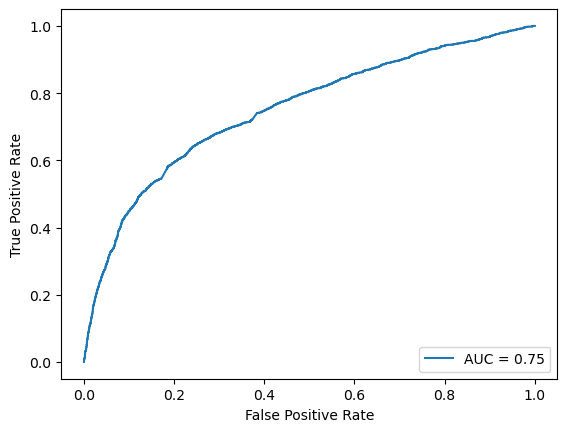

In [273]:
# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr9, tpr9, thresholds9 = roc_curve(y_test_array, y_pred_probs9)

# Calculate the AUC score
auc_score9 = roc_auc_score(y_test_array, y_pred_probs9)

# Plot the ROC curve
roc_display9 = RocCurveDisplay(fpr=fpr9, tpr=tpr9, roc_auc=auc_score9)
roc_display9.plot()
plt.show()

In [278]:
# Define the CNN model for feature extraction
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=16, kernel_size=3, activation='relu',padding='same', input_shape=(num_time_steps, num_features)))
cnn_model.add(MaxPooling1D(pool_size=3))
cnn_model.add(Conv1D(filters=32, padding='same', kernel_size=2, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))


# Define the input shape for the static features
static_input_cnn = Input(shape=(X_train_static.shape[1],))

# Concatenate the output from the CNN and the static input
concatenated_output_cnn = Concatenate()([cnn_model.output, static_input_cnn])

# Add a dense layer with one neuron after the concatenation
output_cnn = Dense(1, activation='sigmoid')(concatenated_output_cnn)

# Create the final model with the concatenated input and the dense layer
final_model_cnn = Model(inputs=[cnn_model.input, static_input_cnn], outputs=output_cnn)

# Compile the final model
final_model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the final model
epochs = 40
batch_size = 256

final_model_cnn.fit([stacked, X_train_static], y_train_array, epochs=epochs, batch_size=batch_size, validation_data=([stacked_test, X_test_static], y_test_array),shuffle=False)

# Make predictions on the test set
y_pred_probs10 = final_model_cnn.predict([stacked_test, X_test_static])
y_pred10 = (y_pred_probs10 >= 0.5).astype(int)

# Evaluate the final model
loss10, accuracy10 = final_model_cnn.evaluate([stacked_test, X_test_static], y_test_array)
print(f'Test Loss: {loss10:.4f}')
print(f'Test Accuracy: {accuracy10:.4f}')

Epoch 1/40
77/77 [==============================] - 2s 16ms/step - loss: 1.1324 - accuracy: 0.6594 - val_loss: 0.5659 - val_accuracy: 0.7580
Epoch 2/40
77/77 [==============================] - 1s 19ms/step - loss: 0.7127 - accuracy: 0.6619 - val_loss: 0.6687 - val_accuracy: 0.6522
Epoch 3/40
77/77 [==============================] - 1s 13ms/step - loss: 0.7196 - accuracy: 0.6378 - val_loss: 0.5929 - val_accuracy: 0.7464
Epoch 4/40
77/77 [==============================] - 1s 16ms/step - loss: 0.6778 - accuracy: 0.6766 - val_loss: 0.5851 - val_accuracy: 0.7624
Epoch 5/40
77/77 [==============================] - 1s 17ms/step - loss: 0.6591 - accuracy: 0.6947 - val_loss: 0.5741 - val_accuracy: 0.7729
Epoch 6/40
77/77 [==============================] - 1s 16ms/step - loss: 0.6453 - accuracy: 0.7052 - val_loss: 0.5646 - val_accuracy: 0.7828
Epoch 7/40
77/77 [==============================] - 1s 17ms/step - loss: 0.6328 - accuracy: 0.7143 - val_loss: 0.5595 - val_accuracy: 0.7830
Epoch 8/40
77

In [279]:
print('Accuracy:', accuracy_score(y_test_array,y_pred10))
print('Precision:', precision_score(y_test_array,y_pred10))
print('Recall:', recall_score(y_test_array,y_pred10))
print('F1 score:', f1_score(y_test_array,y_pred10))

Accuracy: 0.804
Precision: 0.5695039804041642
Recall: 0.467101958814666
F1 score: 0.5132450331125828


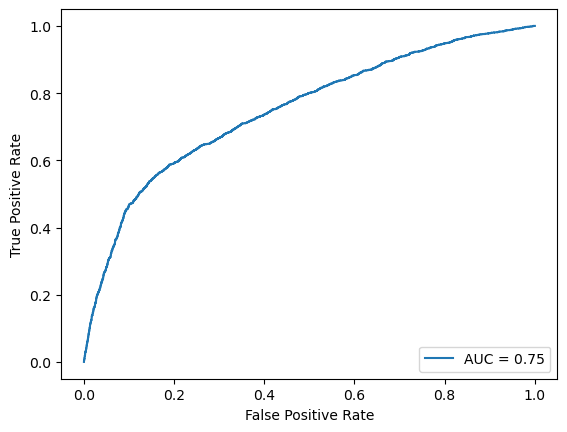

In [280]:
# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr10, tpr10, thresholds10 = roc_curve(y_test_array, y_pred_probs10)

# Calculate the AUC score
auc_score10 = roc_auc_score(y_test_array, y_pred_probs10)

# Plot the ROC curve
roc_display10 = RocCurveDisplay(fpr=fpr10, tpr=tpr10, roc_auc=auc_score10)
roc_display10.plot()
plt.show()

In [281]:
#x test
features_cnn = Model(
    inputs=model_new.inputs,
    outputs=model_new.get_layer(index=5).output,
)

inter_test_cnn = features_cnn.predict(stacked_test)

282/282 [==============================] - 0s 1ms/step


In [284]:

inter_train_cnn = features_cnn.predict(stacked)

614/614 [==============================] - 1s 1ms/step


In [286]:

# Train an XGBoost model
xgb_cnn = xgb.XGBClassifier()
xgb_cnn.fit(inter_train_cnn, y_train_array)

# Make predictions on the validation set
y_pred_cnn = xgb_cnn.predict(inter_test_cnn)

print('Accuracy:', accuracy_score(y_test_array,y_pred_cnn))
print('Precision:', precision_score(y_test_array,y_pred_cnn))
print('Recall:', recall_score(y_test_array,y_pred_cnn))
print('F1 score:', f1_score(y_test_array,y_pred_cnn))

Accuracy: 0.7893333333333333
Precision: 0.5270655270655271
Recall: 0.4645906579608237
F1 score: 0.49386011745862257


In [287]:
#INPUT AFTER LSTM

# Train an RF model
rf_cnn = RandomForestClassifier()
rf_cnn.fit(inter_train_cnn, y_train_array)

# Make predictions on the validation set
y_pred_rf_cnn = rf_cnn.predict(inter_test_cnn)

print('Accuracy:', accuracy_score(y_test_array,y_pred_rf_cnn))
print('Precision:', precision_score(y_test_array,y_pred_rf_cnn))
print('Recall:', recall_score(y_test_array,y_pred_rf_cnn))
print('F1 score:', f1_score(y_test_array,y_pred_rf_cnn))

Accuracy: 0.7917777777777778
Precision: 0.5335243553008596
Recall: 0.46760421898543447
F1 score: 0.49839400428265523
